### LSTM and Spectral Analysis for a Sin Wave

In [1]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

Using TensorFlow backend.


In [20]:
def normalise_windows(window_data):
    '''
    Normalizes the data within each window
    '''
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [53]:
def load_data(filename='sinwave.csv', seq_len=3, normalise_window=True, train_size=0.8):
    with open(filename, 'r') as fin:
        data = fin.readlines()
        data = [line.strip() for line in data]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(train_size * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    # Takes all the previous time steps in the window (except the last one)
    x_train = train[:, :-1]
    # The label is the last time step in each window
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [54]:
x_train, y_train, x_test, y_test = load_data()

In [55]:
x_train

array([[[ 0.        ],
        [ 0.01450446],
        [ 0.02500513]],

       [[ 0.        ],
        [ 0.15911114],
        [ 0.3136478 ]],

       [[ 0.        ],
        [ 0.09813978],
        [ 0.19194569]],

       ..., 
       [[ 0.        ],
        [ 0.24808422],
        [ 0.49124283]],

       [[ 0.        ],
        [ 0.06560736],
        [ 0.12700925]],

       [[ 0.        ],
        [ 0.00629796],
        [ 0.00862453]]])

In [57]:
y_train.shape

(3998,)

In [69]:
def run_lstm(input_dim=1, output_dims=[100,50], input_length=3):
    model = build_model([input_dim, input_length, output_dims[1], output_dims[0]])
    return model

In [70]:
model = run_lstm()

> Compilation Time :  0.023767709732055664


In [71]:
model.fit(
x_train,
y_train,
batch_size=512,
nb_epoch=3,
validation_split=0.05)

ValueError: Error when checking target: expected activation_4 to have shape (None, 100) but got array with shape (3998, 1)

In [ ]:
x_train.shape

In [38]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [45]:
from matplotlib import pyplot as plt

In [50]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=(17,4))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

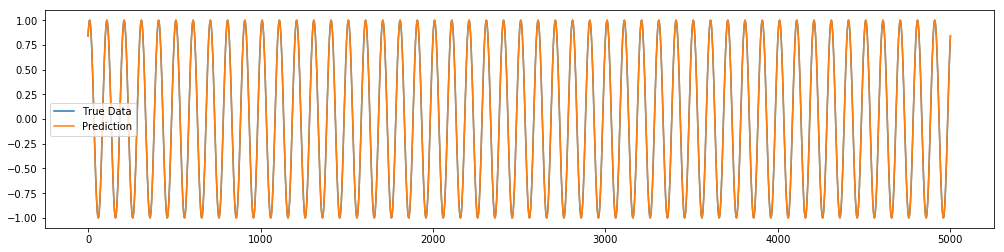

In [51]:
plot_results(data,data)